Raw: (145, 145, 200) (145, 145)
PCA: (145, 145, 20)
Cubes/Labels: (10249, 11, 11, 20) (10249,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 11, 20, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 11, 11, 20, 8)     224       
                                                                 
 batch_normalization (BatchN  (None, 11, 11, 20, 8)    32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 5, 10, 8)      0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 10, 16)      3472      
                                

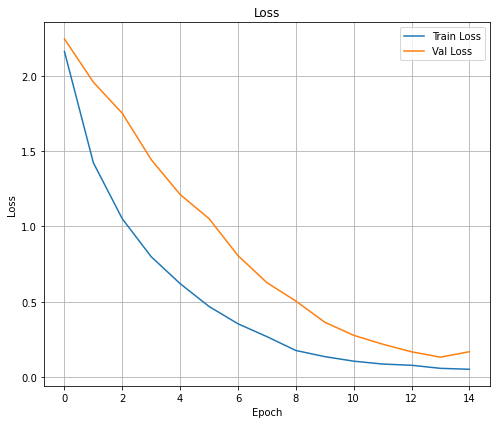

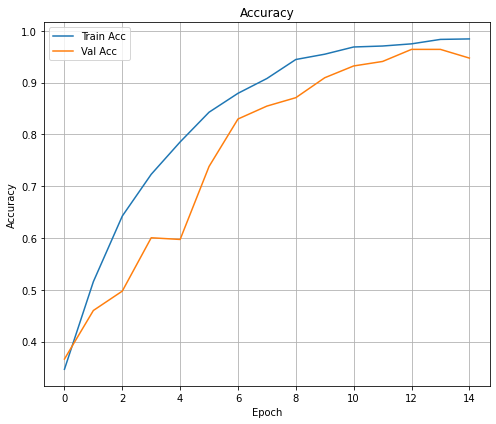


Classification report:
                           precision    recall  f1-score   support

                 Alfalfa     1.0000    0.7895    0.8824        19
          Corn (no-till)     0.8287    0.9825    0.8990       571
         Corn (min-till)     0.9929    0.8404    0.9103       332
                    Corn     0.9759    0.8526    0.9101        95
           Grass-pasture     0.9272    0.9896    0.9574       193
             Grass-trees     0.9797    0.9897    0.9847       292
     Grass-pasture-mowed     1.0000    0.4545    0.6250        11
           Hay-windrowed     0.9844    0.9895    0.9869       191
                    Oats     1.0000    0.3750    0.5455         8
       Soybean (no-till)     0.8680    0.9974    0.9282       389
      Soybean (min-till)     0.9944    0.9114    0.9511       982
         Soybean (clean)     0.9683    0.9030    0.9345       237
                   Wheat     1.0000    1.0000    1.0000        82
                   Woods     0.9711    0.9960    0

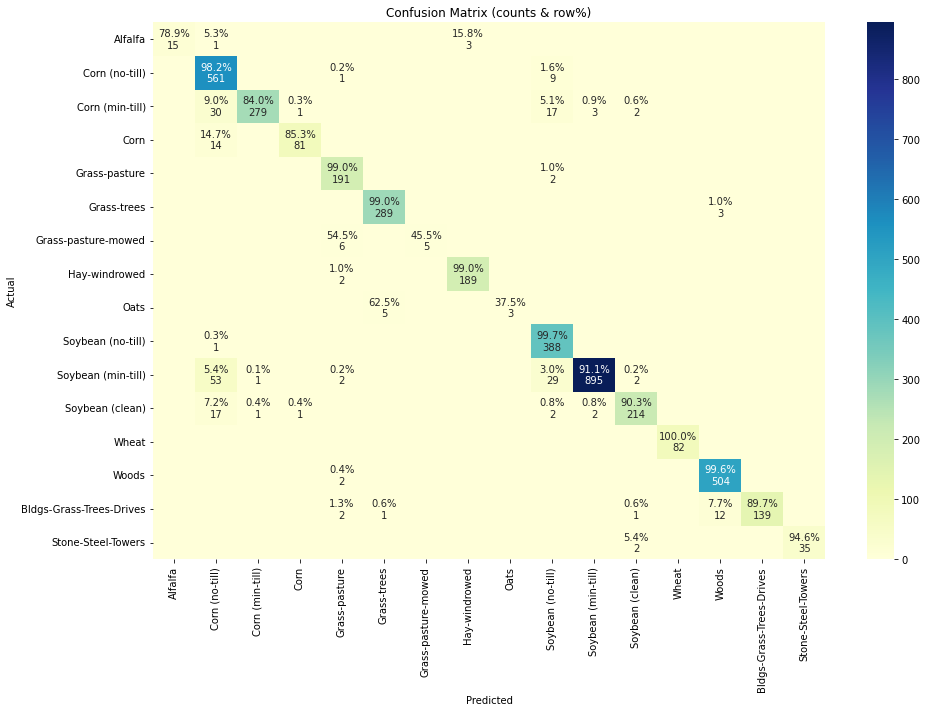

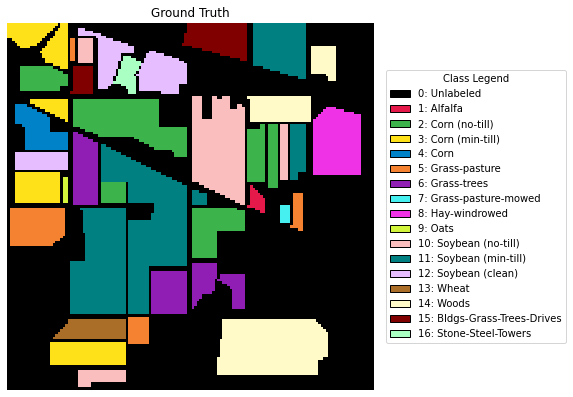

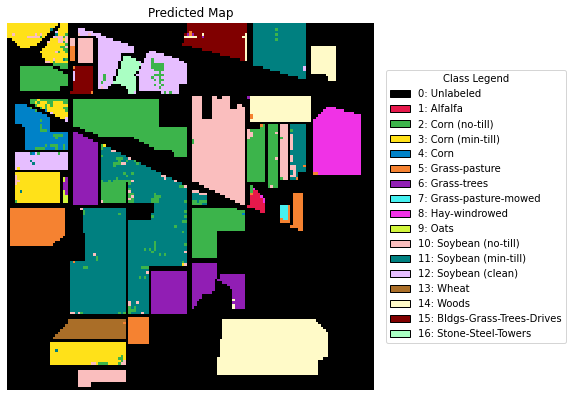

Saved: ground_truth.png, predicted_map.png


In [1]:
# Indian Pines 3D-CNN Code
import os
import time
import gc
import numpy as np
import scipy.io as sio
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

# ----------------------------
# Config
# ----------------------------
DATA_PATH = r"C:\Users\Pushkar Telavane\Desktop\HSI_IMAGE-20250529T110119Z-1-001\HSI_IMAGE\data"

WIN_SIZE = 11               # spatial window 
N_COMPS = 20                # PCA components for spectral dim reduction
TEST_RATIO = 0.40           # TEST Ratio
VAL_RATIO  = 0.30           # Train RATIO
EPOCHS = 15
BATCH = 256
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
gc.collect()

# Indian Pines class labels
IP_CLASSES = {
    0: "Unlabeled",
    1: "Alfalfa",
    2: "Corn (no-till)",
    3: "Corn (min-till)",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean (no-till)",
    11: "Soybean (min-till)",
    12: "Soybean (clean)",
    13: "Wheat",
    14: "Woods",
    15: "Bldgs-Grass-Trees-Drives",
    16: "Stone-Steel-Towers",
}

CLASS_COLORS = [
    "#000000",  # 0 Unlabeled
    "#e6194b",  # 1
    "#3cb44b",  # 2
    "#ffe119",  # 3
    "#0082c8",  # 4
    "#f58231",  # 5
    "#911eb4",  # 6
    "#46f0f0",  # 7
    "#f032e6",  # 8
    "#d2f53c",  # 9
    "#fabebe",  # 10
    "#008080",  # 11
    "#e6beff",  # 12
    "#aa6e28",  # 13
    "#fffac8",  # 14
    "#800000",  # 15
    "#aaffc3",  # 16
]
IP_CMAP = ListedColormap(CLASS_COLORS)
IP_NORM = BoundaryNorm(np.arange(-0.5, 16.5 + 1, 1), IP_CMAP.N)

# ----------------------------
# Loading the Files
# ----------------------------
def load_indian_pines(data_path=DATA_PATH):
    X = sio.loadmat(os.path.join(data_path, "Indian_pines_corrected.mat"))["indian_pines_corrected"]
    y = sio.loadmat(os.path.join(data_path, "Indian_pines_gt.mat"))["indian_pines_gt"]
    return X, y  # X: (145,145,200), y: (145,145)

# ----------------------------
# Preprocessing the Data
# ----------------------------
def pca_reduce(HSI, n_components=N_COMPS, batches=256):
    """Incremental PCA across pixels; returns (H,W,n_components)."""
    H, W, B = HSI.shape
    X = HSI.reshape(-1, B)
    ipca = IncrementalPCA(n_components=n_components)
    for chunk in np.array_split(X, batches):
        ipca.partial_fit(chunk)
    Xr = ipca.transform(X)
    return Xr.reshape(H, W, n_components), ipca

def zero_pad(HSI, margin):
    H, W, B = HSI.shape
    out = np.zeros((H + 2*margin, W + 2*margin, B), dtype=HSI.dtype)
    out[margin:margin+H, margin:margin+W, :] = HSI
    return out

def make_cubes(HSI, GT, win=WIN_SIZE, remove_zero=True):
    """Extract ALL pixel-centered cubes (H*W, win, win, bands) + labels (H*W,)"""
    m = win // 2
    Xpad = zero_pad(HSI, m)
    H, W, B = HSI.shape
    N = H * W
    cubes = np.zeros((N, win, win, B), dtype=HSI.dtype)
    labels = np.zeros((N,), dtype=GT.dtype)
    k = 0
    for r in range(m, m + H):
        for c in range(m, m + W):
            cubes[k] = Xpad[r-m:r+m+1, c-m:c+m+1, :]
            labels[k] = GT[r-m, c-m]
            k += 1
    if remove_zero:
        mask = labels > 0
        cubes = cubes[mask]
        labels = labels[mask] - 1  
    return cubes, labels

def split_train_val_test(X, y, test_ratio=TEST_RATIO, val_ratio=VAL_RATIO, seed=SEED):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_ratio, random_state=seed, stratify=y)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_ratio, random_state=seed, stratify=y_tr)
    return X_tr, X_val, X_te, y_tr, y_val, y_te

# ----------------------------
# 3D CNN Model
# ----------------------------
def build_3d_cnn(input_shape, n_classes=16):
    """
    input_shape: (win, win, bands, 1)
    """
    inp = Input(shape=input_shape)

    # A compact, stable 3D stack
    x = Conv3D(8,  (3,3,3), activation="relu", padding="same")(inp)
    x = BatchNormalization()(x)
    x = MaxPool3D(pool_size=(2,2,2), padding="valid")(x)

    x = Conv3D(16, (3,3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPool3D(pool_size=(2,2,2), padding="valid")(x)

    x = Conv3D(32, (3,3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    out = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ----------------------------
# Reporting helpers
# ----------------------------
def evaluate_and_report(model, X_te, y_te, class_names):
    """
    y_te: integers 0..(C-1). Will one-hot internally for Keras evaluate.
    Returns dict with metrics and predictions.
    """
    n_classes = len(class_names)
    y_te_cat = to_categorical(y_te, num_classes=n_classes)
    t0 = time.time()
    logits = model.predict(X_te, batch_size=256, verbose=0)
    pred = np.argmax(logits, axis=1)
    infer_time = time.time() - t0

    loss, acc = model.evaluate(X_te, y_te_cat, batch_size=256, verbose=0)
    cm = confusion_matrix(y_te, pred, labels=np.arange(n_classes))
    cls_rep = classification_report(y_te, pred, target_names=class_names, digits=4)
    oa = accuracy_score(y_te, pred)
    each_acc = np.nan_to_num(np.diag(cm) / np.maximum(cm.sum(axis=1), 1))
    aa = each_acc.mean()
    kappa = cohen_kappa_score(y_te, pred)

    return {
        "loss": loss, "acc": acc, "cm": cm, "report": cls_rep,
        "oa": oa, "each_acc": each_acc, "aa": aa, "kappa": kappa,
        "pred": pred, "infer_time": infer_time
    }

def plot_training(history):
    plt.figure(figsize=(7,6)); plt.grid(True)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,6)); plt.grid(True)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

def show_class_map(arr2d, title, save_path=None):
    """
    Show labeled map with legend mapping class IDs to names.
    Expects arr2d using same ID system as GT: 0..16 (0 unlabeled).
    """
    present = np.unique(arr2d.astype(int))
    plt.figure(figsize=(8,8))
    plt.imshow(arr2d.astype(int), cmap=IP_CMAP, norm=IP_NORM, interpolation="nearest")
    plt.title(title); plt.axis("off")

    handles = []
    for cid in present:
        if 0 <= cid <= 16:
            label = f"{cid}: {IP_CLASSES.get(cid,'?')}"
            handles.append(Patch(facecolor=CLASS_COLORS[cid], edgecolor="k", label=label))
    if handles:
        plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5),
                   frameon=True, title="Class Legend")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# ----------------------------
# Full map prediction 
# ----------------------------
def predict_full_map(model, X_pca, GT, win=WIN_SIZE):
    """
    X_pca: (H,W,B) PCA-reduced; GT: (H,W) with 0 as unlabeled.
    Returns outputs with same coding as GT: 0..16 (0 retained for unlabeled).
    """
    H, W, B = X_pca.shape
    m = win // 2
    Xpad = zero_pad(X_pca, m)
    out = np.zeros((H, W), dtype=np.int32)

    for r in range(H):
        for c in range(W):
            if GT[r, c] == 0:
                continue
            patch = Xpad[r:r+win, c:c+win, :] 
            xin = patch[np.newaxis, ..., np.newaxis].astype("float32")  
            pred = np.argmax(model.predict(xin, verbose=0), axis=1)[0] 
            out[r, c] = pred + 1  
    return out

# ----------------------------
# Main Function
# ----------------------------
if __name__ == "__main__":
    # Loading the Dataset File
    HSI, GT = load_indian_pines(DATA_PATH)
    print("Raw:", HSI.shape, GT.shape)  

    # Standarizing the Data
    H, W, B = HSI.shape
    flat = HSI.reshape(-1, B).astype(np.float32)
    scaler = StandardScaler().fit(flat)
    flat_std = scaler.transform(flat)
    HSI_std = flat_std.reshape(H, W, B)

    # PCA reduction
    HSI_pca, ipca = pca_reduce(HSI_std, n_components=N_COMPS)
    print("PCA:", HSI_pca.shape)

    # Building dataset of cubes for training
    cubes, labels = make_cubes(HSI_pca, GT, win=WIN_SIZE, remove_zero=True)  
    print("Cubes/Labels:", cubes.shape, labels.shape)
    n_classes = int(labels.max() + 1)  
    # Splitting the dataset
    X_tr, X_val, X_te, y_tr, y_val, y_te = split_train_val_test(cubes, labels, TEST_RATIO, VAL_RATIO, SEED)

    # Adding channel dim for Conv3D
    X_tr = X_tr[..., np.newaxis].astype("float32")
    X_val = X_val[..., np.newaxis].astype("float32")
    X_te  = X_te[...,  np.newaxis].astype("float32")

    y_tr_cat = to_categorical(y_tr, num_classes=n_classes)
    y_val_cat = to_categorical(y_val, num_classes=n_classes)

    # Building & training model
    model = build_3d_cnn(input_shape=X_tr.shape[1:], n_classes=n_classes)
    model.summary()

    t0 = time.time()
    history = model.fit(
        X_tr, y_tr_cat,
        validation_data=(X_val, y_val_cat),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=1
    )
    train_time = time.time() - t0
    print(f"Training time: {train_time:.1f}s")

    # Training curves
    plot_training(history)

    # Evaluating on test
    class_names = [IP_CLASSES[i+1] for i in range(n_classes)]  
    metrics = evaluate_and_report(model, X_te, y_te, class_names)
    print("\nClassification report:\n", metrics["report"])
    print(f"OA: {metrics['oa']*100:.2f}% | AA: {metrics['aa']*100:.2f}% | Kappa: {metrics['kappa']*100:.2f}%")
    print(f"Test Loss: {metrics['loss']:.4f} | Test Acc: {metrics['acc']*100:.2f}% | Inference time: {metrics['infer_time']:.2f}s")

    # Confusion matrix heatmap (percent w/ counts)
    cm = metrics["cm"]
    cm_sum = cm.sum(axis=1, keepdims=True).clip(min=1)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]; p = cm_perc[i, j]
            annot[i, j] = f"{p:.1f}%\n{c}" if c else ""
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(14,10))
    sns.heatmap(df_cm, annot=annot, fmt="", cmap="YlGnBu")
    plt.title("Confusion Matrix (counts & row%)"); plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.show()

    # Predicting full map
    outputs = predict_full_map(model, HSI_pca, GT, win=WIN_SIZE)  

    # Plotting
    show_class_map(GT, "Ground Truth", save_path="ground_truth.png")
    show_class_map(outputs, "Predicted Map", save_path="predicted_map.png")
    print("Saved: ground_truth.png, predicted_map.png")
